In [1]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
import datetime 
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.messages import HumanMessage

load_dotenv()

True

### Define the schema

In [35]:
from typing import  List
from pydantic import BaseModel, Field

class Reflection(BaseModel):
     missing: str = Field(description="Critique of what is missing.")
     superfluous: str = Field(description="Critique of what is superfluous.")

class AnswerQuestion(BaseModel):
     """Answer to the Question"""
     answer: str = Field(description="~250 word detailed answer to the question")
     search_queries: List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer")
     reflect: Reflection = Field(description="Your refelcton on the initial answer")

class ReviseAnswer(AnswerQuestion):
     """Revise your original answer to your question."""
     references: List[str] = Field(description="Citations motivating your update answer.")


## define the prompt template

In [36]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",
         """ You are expert AI Researcher
         Current Time: {time}
         
         1. {first_instruction}
         2. Reflect and critique your answer. Be severe to maximize improvement.
         3. After the reflectiom, **List 1-3 search queires seperately** for researching improvements.
         Do not include them inside the reflection
         """),
         MessagesPlaceholder(variable_name="messages"),
         ("system",
          "Answer the user's question above using thre required format.")
    ]
).partial(  # .partials is used to prepopulate prompt template before invoking it on LLM
    time=lambda: datetime.datetime.now().isoformat()
)

### build the full prompt template, the llm and the parser

In [37]:
first_responder_prompt_template = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250word answer"
) # the full prompt template

tools=[AnswerQuestion]  #build the tools
llm = ChatOpenAI(model="gpt-4o")  # build the llm
pydantic_parser = PydanticToolsParser(tools=tools) # the parser

### Create the first responder chain

In [40]:
first_responder_chain = first_responder_prompt_template | llm.bind_tools(tools=tools,tool_choice='AnswerQuestion') 


### prompt instruction for the revision and it chain

In [41]:
revise_instructions = """
Revise your  previous answer using the new information
- You should use the revious critique to add important information to your answer.
- You MUST inlude numerical citations in your revised answer to ensure it can ver verified
- add a "References" section to the botton of your anwser (which does not count towards the word limit). 
in form of:
    - [1] https://example.com
    - [2] https://example.com
- You should use the previous critique to remove superfluous information from your answer and make SURE it is not more th
250 words.
"""

# add the actor template and the revisor template together
 # add the actor template and the revisor template together
revisor_chain = actor_prompt_template.partial(
    first_instruction = revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice='ReviseAnswer')

In [7]:
# ====TEST==== Get the response
response = first_responder_chain.invoke({
    "messages":[HumanMessage(content="write me a blog post on how small business can leverage AI to grow")]
})



In [9]:
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_ZIV6rvw8UnatDIYXg7yfLIGs', 'function': {'arguments': '{"answer":"In today’s fast-paced digital landscape, small businesses must adopt innovative strategies to remain competitive and efficient. Artificial Intelligence (AI) is no longer an exclusive tool for giant corporations; small businesses can also leverage AI to drive growth and enhance operations. Here’s how:\\n\\n1. **Customer Insights and Personalized Marketing:** AI tools can analyze customer data to provide valuable insights into purchasing patterns and preferences. This enables businesses to create tailored marketing campaigns that resonate with their target audience, thus enhancing customer engagement and boosting sales.\\n\\n2. **Automating Routine Tasks:** One of AI\'s most significant advantages is its ability to automate monotonous tasks, saving valuable time for small business owners to focus on strategy and innovation. AI-powered chatbots, for example, can handl

### Generate Executor Agent - Create node from responsemm

In [43]:
import json
from typing import List, Dict, Any 
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage, HumanMessage
from langchain_community.tools import TavilySearchResults
# create the Tavily Search tool
tavily_tools = TavilySearchResults(max_results=3)



def execute_tools(state:List[BaseMessage]) ->List[BaseMessage]:
    #from the list of message, get the last message (which is usally an AIMessage tool message)
    last_ai_message = state[-1] 

    #extract tool calls from the AI Message
    # start by checking if the last ai message is a tool call, if not return []
    if not hasattr(last_ai_message,"tool_calls") or not last_ai_message.tool_calls:
        return []
    
    tool_messages = [] #this will store all the tools
    # if last_ai_message is a tool then loop through all the available tools
    for tool_call in last_ai_message.tool_calls:
        if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]: # is there a tool called AnswerQuestion or ReviseAnswer
            call_id = tool_call["id"] #if you found any of then the get their id
            search_queries = tool_call["args"].get("search_queries", []) # also get the search_queries list data inside args dict

            #loop through the list in search_queries and store the result in query_results
            #each search_queries item contain a query string. This will be passed to tavily to generate respond
            query_results = {}
            for query in search_queries:
                result = tavily_tools.invoke(query) # this uses tavily tool to generate a list of 3 response for each query in search_queries
                query_results[query]= result # store the response in the query_results dictionary

            #create a tool with the generated result
            tool_messages.append(
                ToolMessage(
                    content = json.dumps(query_results),
                    tool_call_id = call_id,
                )
            )
    return  state + tool_messages

 ### Integrate Code together with Graph

In [48]:
from typing import List
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph import END, MessageGraph

 

MAX_ITERATION = 2

graph = MessageGraph()

graph.add_node("draft", first_responder_chain)
graph.add_node("execute_tools", execute_tools)
graph.add_node("revisor", revisor_chain)


graph.set_entry_point("draft") # from start node, add the draft node
graph.add_edge("draft", "execute_tools") # from draft node, add the execute tool node
graph.add_edge("execute_tools", "revisor")# from execute node add revisor node

def event_loop(state: List[BaseMessage])->str:
    # check the number of tools are in the state message.
    #this is to capture how many times the tool is called
    count_tool_visits = sum((item, ToolMessage) for item in state)
    num_iterations = count_tool_visits

    #if the counted tool call is greater than the maximum allowed then end the program
    # if not, call the tool again.
    if num_iterations > MAX_ITERATION:
        return "end"
    return "continue"

# from revisor node add tools node and let tools node decide either to goto END node or loop back to revisor node
# graph.add_conditional_edges("revisor", event_loop) 
graph.add_conditional_edges(
    "revisor",
    event_loop,
    {
        "end":END,
        "continue": "execute_tools"
    }
)

app = graph.compile()



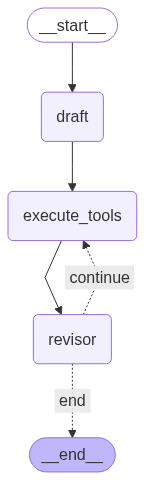

In [49]:
app

In [58]:
response =app.invoke("Write about how small businesses can leverage AI to grow")


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_yy8PY5qnMOOJunpKfdiifC72", 'type': 'invalid_request_error', 'param': 'messages.[3].role', 'code': None}}

In [59]:
# answers = response[-1].tool_calls[0]["args"]["answer"]
# print(answers)

print(type(response), response)

<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_ZIV6rvw8UnatDIYXg7yfLIGs', 'function': {'arguments': '{"answer":"In today’s fast-paced digital landscape, small businesses must adopt innovative strategies to remain competitive and efficient. Artificial Intelligence (AI) is no longer an exclusive tool for giant corporations; small businesses can also leverage AI to drive growth and enhance operations. Here’s how:\\n\\n1. **Customer Insights and Personalized Marketing:** AI tools can analyze customer data to provide valuable insights into purchasing patterns and preferences. This enables businesses to create tailored marketing campaigns that resonate with their target audience, thus enhancing customer engagement and boosting sales.\\n\\n2. **Automating Routine Tasks:** One of AI\'s most significant advantages is its ability to automate monotonous tasks, saving valuable time for small business owners to focus on strategy and innovati

In [53]:
response.tool_calls

[{'name': 'AnswerQuestion',
  'args': {'answer': "In today’s fast-paced digital landscape, small businesses must adopt innovative strategies to remain competitive and efficient. Artificial Intelligence (AI) is no longer an exclusive tool for giant corporations; small businesses can also leverage AI to drive growth and enhance operations. Here’s how:\n\n1. **Customer Insights and Personalized Marketing:** AI tools can analyze customer data to provide valuable insights into purchasing patterns and preferences. This enables businesses to create tailored marketing campaigns that resonate with their target audience, thus enhancing customer engagement and boosting sales.\n\n2. **Automating Routine Tasks:** One of AI's most significant advantages is its ability to automate monotonous tasks, saving valuable time for small business owners to focus on strategy and innovation. AI-powered chatbots, for example, can handle customer inquiries round-the-clock, enhancing customer service without incur

In [54]:
response.tool_calls[0]['args']['answer']

"In today’s fast-paced digital landscape, small businesses must adopt innovative strategies to remain competitive and efficient. Artificial Intelligence (AI) is no longer an exclusive tool for giant corporations; small businesses can also leverage AI to drive growth and enhance operations. Here’s how:\n\n1. **Customer Insights and Personalized Marketing:** AI tools can analyze customer data to provide valuable insights into purchasing patterns and preferences. This enables businesses to create tailored marketing campaigns that resonate with their target audience, thus enhancing customer engagement and boosting sales.\n\n2. **Automating Routine Tasks:** One of AI's most significant advantages is its ability to automate monotonous tasks, saving valuable time for small business owners to focus on strategy and innovation. AI-powered chatbots, for example, can handle customer inquiries round-the-clock, enhancing customer service without incurring extra staffing costs.\n\n3. **Enhanced Decis

In [56]:
response.tool_calls[0]["args"]["answer"]

"In today’s fast-paced digital landscape, small businesses must adopt innovative strategies to remain competitive and efficient. Artificial Intelligence (AI) is no longer an exclusive tool for giant corporations; small businesses can also leverage AI to drive growth and enhance operations. Here’s how:\n\n1. **Customer Insights and Personalized Marketing:** AI tools can analyze customer data to provide valuable insights into purchasing patterns and preferences. This enables businesses to create tailored marketing campaigns that resonate with their target audience, thus enhancing customer engagement and boosting sales.\n\n2. **Automating Routine Tasks:** One of AI's most significant advantages is its ability to automate monotonous tasks, saving valuable time for small business owners to focus on strategy and innovation. AI-powered chatbots, for example, can handle customer inquiries round-the-clock, enhancing customer service without incurring extra staffing costs.\n\n3. **Enhanced Decis